In [1]:
#Dataset is from
#https://www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [4]:
!unzip \*.zip && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [5]:
#Wrangle function

def wrangle(filepath):

  df = pd.read_csv('ndtv_data_final.csv')

  #Drop Duplicate Column
  df.drop(columns = ['Unnamed: 0','Name'], inplace=True)

  #Feature engineer total pixels and move new column to position after Resolution
  df['Screen_pixels'] = df['Resolution x'] * df['Resolution y']

  new_order = ['Brand', 'Model', 'Battery capacity (mAh)',
       'Screen size (inches)', 'Touchscreen', 'Resolution x', 'Resolution y', 'Screen_pixels',
       'Processor', 'RAM (MB)', 'Internal storage (GB)', 'Rear camera',
       'Front camera', 'Operating system', 'Wi-Fi', 'Bluetooth', 'GPS',
       'Number of SIMs', '3G', '4G/ LTE', 'Price']
  df = df.loc[:,new_order]


  #Encode Yes and No to 1 and 0 respectively
  df['Touchscreen'] = df['Touchscreen'].str.replace('Yes', '1')
  df['Touchscreen'] = df['Touchscreen'].str.replace('No', '0')

  df['Wi-Fi'] = df['Wi-Fi'].str.replace('Yes', '1')
  df['Wi-Fi'] = df['Wi-Fi'].str.replace('No', '0')

  df['Bluetooth'] = df['Bluetooth'].str.replace('Yes', '1')
  df['Bluetooth'] = df['Bluetooth'].str.replace('No', '0')

  df['GPS'] = df['GPS'].str.replace('Yes', '1')
  df['GPS'] = df['GPS'].str.replace('No', '0')

  df['4G/ LTE'] = df['4G/ LTE'].str.replace('Yes', '1')
  df['4G/ LTE'] = df['4G/ LTE'].str.replace('No', '0')

  df['3G'] = df['3G'].str.replace('Yes', '1')
  df['3G'] = df['3G'].str.replace('No', '0')

  

  df.rename(columns = {'Resolution x':'Resolution_Width', 'Resolution y':'Resolution_Height'},inplace=True)
  
  #Replace spaces with underscores
  df.columns = df.columns.str.replace(" ","_")
  
  return df

In [6]:
df = wrangle('ndtv_data_final.csv')

# Exploratory Data Analysis

In [7]:
# new_order = ['Name', 'Brand', 'Model', 'Battery capacity (mAh)',
#        'Screen size (inches)', 'Touchscreen', 'Resolution x', 'Resolution y', 'Screen_pixels',
#        'Processor', 'RAM (MB)', 'Internal storage (GB)', 'Rear camera',
#        'Front camera', 'Operating system', 'Wi-Fi', 'Bluetooth', 'GPS',
#        'Number of SIMs', '3G', '4G/ LTE', 'Price']
# df.loc[:,new_order]


In [8]:
df['Operating_system'].value_counts()

Android       1299
Windows         19
iOS             17
Cyanogen        10
BlackBerry      10
Tizen            3
Sailfish         1
Name: Operating_system, dtype: int64

In [9]:
onehot = pd.get_dummies(df['Operating_system'])
onehot

,Android,BlackBerry,Cyanogen,Sailfish,Tizen,Windows,iOS
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1354,1,0,0,0,0,0,0
1355,1,0,0,0,0,0,0
1356,1,0,0,0,0,0,0
1357,1,0,0,0,0,0,0


In [10]:
onehot = pd.DataFrame(onehot)


In [11]:
df = pd.concat([df,onehot],axis=1)

In [12]:
df

,Brand,Model,Battery_capacity_(mAh),Screen_size_(inches),Touchscreen,Resolution_Width,Resolution_Height,Screen_pixels,Processor,RAM_(MB),...,3G,4G/_LTE,Price,Android,BlackBerry,Cyanogen,Sailfish,Tizen,Windows,iOS
0,OnePlus,7T Pro McLaren Edition,4085,6.67,1,1440,3120,4492800,8,12000,...,1,1,58998,1,0,0,0,0,0,0
1,Realme,X2 Pro,4000,6.50,1,1080,2400,2592000,8,6000,...,1,1,27999,1,0,0,0,0,0,0
2,Apple,iPhone 11 Pro Max,3969,6.50,1,1242,2688,3338496,6,4000,...,1,1,106900,0,0,0,0,0,0,1
3,Apple,iPhone 11,3110,6.10,1,828,1792,1483776,6,4000,...,1,1,62900,0,0,0,0,0,0,1
4,LG,G8X ThinQ,4000,6.40,1,1080,2340,2527200,8,6000,...,0,0,49990,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,Intex,Aqua A2,1500,4.00,1,480,800,384000,4,512,...,1,0,2599,1,0,0,0,0,0,0
1355,Videocon,Infinium Z51 Nova+,2000,5.00,1,480,854,409920,4,1000,...,1,0,2940,1,0,0,0,0,0,0
1356,Intex,Aqua Y4,1700,4.50,1,480,854,409920,2,512,...,1,0,2999,1,0,0,0,0,0,0
1357,iBall,Andi4 B20,1250,4.00,1,480,800,384000,1,256,...,1,0,2498,1,0,0,0,0,0,0


In [13]:
df.columns

new_order2 = ['Brand', 'Model', 'Battery_capacity_(mAh)', 'Screen_size_(inches)',
       'Touchscreen', 'Resolution_Width', 'Resolution_Height', 'Screen_pixels',
       'Processor', 'RAM_(MB)', 'Internal_storage_(GB)', 'Rear_camera',
       'Front_camera', 'Android', 'BlackBerry','Cyanogen', 'Sailfish', 'Tizen', 
       'Windows', 'iOS', 'Wi-Fi', 'Bluetooth', 'GPS','Number_of_SIMs', '3G', 
       '4G/_LTE', 'Price']
df = df.loc[:,new_order2]

In [14]:
convert1 = ['Touchscreen','Wi-Fi', 'Bluetooth', 'GPS','3G', '4G/_LTE']
convert2 =['Android', 'BlackBerry','Cyanogen', 'Sailfish', 'Tizen', 'Windows', 'iOS']

df[convert1] = df[convert1].astype(int)
df[convert2] = df[convert2].astype(int)

In [15]:
df2 =df.copy()

# Train and Fit Model

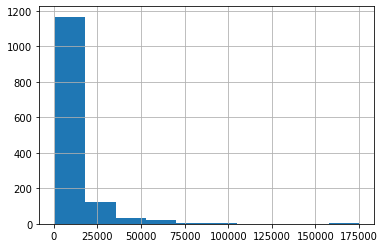

In [16]:
target = 'Price'
X =df.drop(columns=target)
y=df[target]
y.hist()

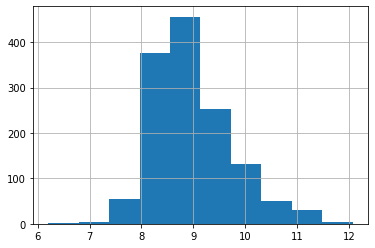

In [17]:
y=np.log(y)
y.hist()

In [18]:
baseline = [y.mean()]* len(y)
baseline_mae = mean_absolute_error(y, baseline)
print('The baseline mae is: ', baseline_mae)

The baseline mae is:  0.588906612920655


In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [20]:


model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    LinearRegression(fit_intercept=True)
)

model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('linearregression', LinearRegression())])

In [21]:
y_pred = model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
model.score(X_test,y_test)

0.30056254772244684


0.71809090697123

# ^^Model performs better than the baseline^^

In [22]:
model2 = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    Ridge(fit_intercept=True)
)

model2.fit(X_train,y_train)

y_pred = model2.predict(X_test)
print("Model mean absolute error: ", mean_absolute_error(y_test, y_pred))
print("Model score: ", model2.score(X_test,y_test))

Model mean absolute error:  0.2958480835283383
Model score:  0.725537125584947


In [23]:
df2.drop(columns='Model',inplace=True)

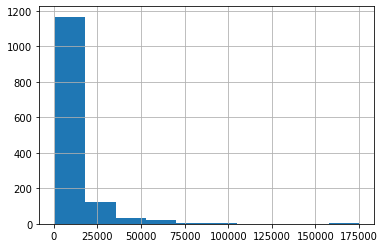

In [24]:
target = 'Price'
X2 =df2.drop(columns=target)
y2=df2[target]
y2.hist()

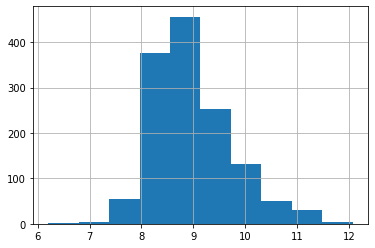

In [25]:
y2=np.log(y2)
y2.hist()

# Best Model Score

In [26]:
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,test_size=0.2,random_state=42)

In [27]:
model2.fit(X2_train,y2_train)

y2_pred = model2.predict(X2_test)
print("Model mean absolute error: ", mean_absolute_error(y2_test, y2_pred))
print("Model r2 score: ", r2_score(y2_test, y2_pred))


Model mean absolute error:  0.2942687413726567
Model r2 score:  0.7294499486078845


# Permutated Features

In [29]:
from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(model2,X2_test,y2_test, random_state=42)

data_perm = {'importance_mean':perm_imp['importances_mean'],
             'importance_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data_perm, index=X2_test.columns).sort_values('importance_mean')

In [31]:
df_perm

,importance_mean,importance_std
Battery_capacity_(mAh),-0.003780,0.004605
Windows,-0.000732,0.001570
Wi-Fi,-0.000088,0.000268
3G,-0.000010,0.001054
Tizen,0.000000,0.000000
Sailfish,0.000000,0.000000
4G/_LTE,0.000187,0.000260
BlackBerry,0.000455,0.000363
Bluetooth,0.000978,0.000701
Cyanogen,0.001018,0.001944


In [32]:
# Permute the values in the more important column
feature = 'Processor'
X2_test_permuted = X2_test.copy()

# Fill in missing values
X2_test_permuted[feature].fillna(value = X2_test_permuted[feature].median(), inplace=True)

# Permute
X2_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model2.score(X2_test, y2_test))
print('Validation Accuracy (permuted)', model2.score(X2_test_permuted, y2_test))



Feature permuted:  Processor
Validation Accuracy 0.7294499486078845
Validation Accuracy (permuted) 0.7306036932733091


In [33]:
feature = 'Screen_pixels'
X2_test_permuted = X2_test.copy()

# Fill in missing values
X2_test_permuted[feature].fillna(value = X2_test_permuted[feature].median(), inplace=True)

# Permute
X2_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model2.score(X2_test, y2_test))
print('Validation Accuracy (permuted)', model2.score(X2_test_permuted, y2_test))


Feature permuted:  Screen_pixels
Validation Accuracy 0.7294499486078845
Validation Accuracy (permuted) 0.7122962238169672


In [34]:
feature = 'RAM_(MB)'
X2_test_permuted = X2_test.copy()

# Fill in missing values
X2_test_permuted[feature].fillna(value = X2_test_permuted[feature].median(), inplace=True)

# Permute
X2_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model2.score(X2_test, y2_test))
print('Validation Accuracy (permuted)', model2.score(X2_test_permuted, y2_test))

#Significant feature for effecting price

Feature permuted:  RAM_(MB)
Validation Accuracy 0.7294499486078845
Validation Accuracy (permuted) 0.6337281005104767


In [35]:
feature = 'Internal_storage_(GB)'
X2_test_permuted = X2_test.copy()

# Fill in missing values
X2_test_permuted[feature].fillna(value = X2_test_permuted[feature].median(), inplace=True)

# Permute
X2_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model2.score(X2_test, y2_test))
print('Validation Accuracy (permuted)', model2.score(X2_test_permuted, y2_test))

#Significant feature for effecting price

Feature permuted:  Internal_storage_(GB)
Validation Accuracy 0.7294499486078845
Validation Accuracy (permuted) 0.6816091701482209


In [36]:
feature = 'Brand'
X2_test_permuted = X2_test.copy()

# Fill in missing values
X2_test_permuted[feature].fillna(value = X2_test_permuted[feature].mode(), inplace=True)

# Permute
X2_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model2.score(X2_test, y2_test))
print('Validation Accuracy (permuted)', model2.score(X2_test_permuted, y2_test))

#Significant feature for effecting price

Feature permuted:  Brand
Validation Accuracy 0.7294499486078845
Validation Accuracy (permuted) 0.5694484925450249


In [37]:
feature = 'Number_of_SIMs'
X2_test_permuted = X2_test.copy()

# Fill in missing values
X2_test_permuted[feature].fillna(value = X2_test_permuted[feature].median(), inplace=True)

# Permute
X2_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model2.score(X2_test, y2_test))
print('Validation Accuracy (permuted)', model2.score(X2_test_permuted, y2_test))


Feature permuted:  Number_of_SIMs
Validation Accuracy 0.7294499486078845
Validation Accuracy (permuted) 0.7282765247881446


In [38]:
feature = 'Screen_size_(inches)'
X2_test_permuted = X2_test.copy()

# Fill in missing values
X2_test_permuted[feature].fillna(value = X2_test_permuted[feature].median(), inplace=True)

# Permute
X2_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model2.score(X2_test, y2_test))
print('Validation Accuracy (permuted)', model2.score(X2_test_permuted, y2_test))


Feature permuted:  Screen_size_(inches)
Validation Accuracy 0.7294499486078845
Validation Accuracy (permuted) 0.7001512921063535


In [39]:
feature = 'Processor'
X2_test_permuted = X2_test.copy()

# Fill in missing values
X2_test_permuted[feature].fillna(value = X2_test_permuted[feature].median(), inplace=True)

# Permute
X2_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model2.score(X2_test, y2_test))
print('Validation Accuracy (permuted)', model2.score(X2_test_permuted, y2_test))

Feature permuted:  Processor
Validation Accuracy 0.7294499486078845
Validation Accuracy (permuted) 0.7254237899458564


In [40]:
feature = '4G/_LTE'
X2_test_permuted = X2_test.copy()

# Fill in missing values
X2_test_permuted[feature].fillna(value = X2_test_permuted[feature].median(), inplace=True)

# Permute
X2_test_permuted[feature] = np.random.permutation(X_test[feature])

print('Feature permuted: ', feature)
print('Validation Accuracy', model2.score(X2_test, y2_test))
print('Validation Accuracy (permuted)', model2.score(X2_test_permuted, y2_test))


Feature permuted:  4G/_LTE
Validation Accuracy 0.7294499486078845
Validation Accuracy (permuted) 0.7289581640196305


# Partial Dependance Plot

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


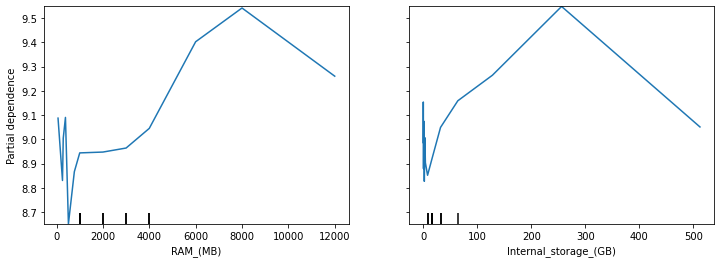

In [41]:
from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(1,1, figsize=(12,4))
plot_partial_dependence(model2, 
                        features=['RAM_(MB)','Internal_storage_(GB)'], 
                        X=X2, grid_resolution=50, ax=ax);